# Set B.1.351 RBD DMS ACE2 binding and expression scores for serum mapping
We want to make sure that the filters chosen for the ACE2 binding and RBD expression scores are reasonable such that spurious antibody-escpae mutations that merely fall into the antibody-escape gate due to their poor folding or expression are removed. 

But, we also want to make sure we aren't throwing out many mutations that are found in nature at reasonable numbers. 

In [1]:
import os

from IPython.display import display, HTML

import math
import numpy as np
import pandas as pd
from scipy import stats

from plotnine import *

from dms_variants.constants import CBPALETTE

import yaml

Read config file

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Define input and output directories

In [3]:
datadir = 'data'
resultsdir = config['bind_expr_filters_dir']

os.makedirs(resultsdir, exist_ok=True)

Read in the new filters for DMS ACE2 binding and expression scores. 

In [4]:
og_thresholds={'delta_bind':-2.35, 'delta_expr':-1.0}
new_thresholds={'delta_bind':config['escape_score_min_bind_mut'], 'delta_expr':config['escape_score_min_expr_mut']}

og_thresholds_df=pd.DataFrame.from_dict({'metric': ['delta_bind', 'delta_expr'], 'score': [-2.35,-1.0]})
new_filter_df=pd.DataFrame({'metric': ['delta_bind', 'delta_expr'], 'score':[config['escape_score_min_bind_mut'],config['escape_score_min_expr_mut']]})
display(HTML(new_filter_df.to_html(index=False)))

metric,score
delta_bind,-3.0
delta_expr,-1.0


In [5]:
gisaid_counts_file = config['gisaid_mutation_counts']
dms_scores_file = config['prelim_mut_bind_expr']
og_dms_file = config['early2020_mut_bind_expr']

### First, just plot the correlations between libraries

In [6]:
dms_corrs = pd.DataFrame()

for lib in ['lib1', 'lib2']:
    for m in ['bind', 'expr']:
        
        df = (pd.read_csv(dms_scores_file).rename(columns={'position': 'site'})
                     [['wildtype', 'mutation', 'site', 'mutant', f'delta_{m}_{lib}']]
                     .assign(not_WT=lambda x: x['wildtype']!=x['mutant'])
                     .query('not_WT')
                     .drop(columns=['not_WT'])
                     .assign(metric=f'delta_{m}',
                             library=lib,
                            )
              .rename(columns={f'delta_{m}_{lib}': 'score'})
                     )
        dms_corrs = pd.concat([dms_corrs, df])

print(len(dms_corrs))
display(HTML(dms_corrs.head().to_html(index=False)))

15276


wildtype,mutation,site,mutant,score,metric,library
N,N331A,331,A,0.10425,delta_bind,lib1
N,N331C,331,C,-0.14457,delta_bind,lib1
N,N331D,331,D,-0.02461,delta_bind,lib1
N,N331E,331,E,0.14659,delta_bind,lib1
N,N331F,331,F,-0.13788,delta_bind,lib1


/loc/scratch/11200631/ipykernel_3099/218136499.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Saving plot to results/bind_expr_filters/replicates-corr.pdf


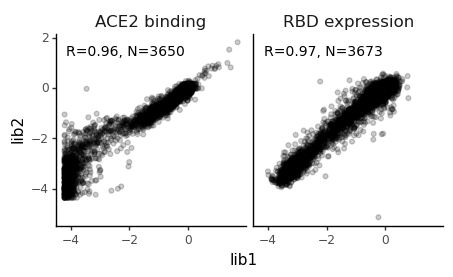

In [7]:
# wide data frame with each library's score in a different column
df_wide = (
    dms_corrs
    .replace({'delta_bind': 'ACE2 binding', 'delta_expr': 'RBD expression'})
    # now make columns for each library, only keep mutants with scores for both libs
    .pivot_table(index=['mutation', 'metric'],
                 columns='library',
                 values='score')
    .reset_index()
    .dropna(axis=0)
    )

# correlations between libraries
corrs = (
    df_wide
    .groupby('metric')
    ['lib1', 'lib2']
    .corr(method='pearson')
    .reset_index()
    .query('library == "lib1"')
    .assign(correlation=lambda x: 'R=' + x['lib2'].round(2).astype(str))
    [['metric', 'correlation']]
    # add number of mutations measured
    .merge(df_wide
           .groupby('metric')
           .size()
           .rename('n')
           .reset_index()
           )
    .assign(correlation=lambda x: x['correlation'] + ', N=' + x['n'].astype(str))
    )
    
# plot correlations
xmin = df_wide['lib1'].min()
xspan = df_wide['lib1'].max() - xmin
ymin = df_wide['lib2'].min()
yspan = df_wide['lib2'].max() - ymin

p = (ggplot(df_wide) +
     aes('lib1', 'lib2') +
     geom_point(alpha=0.2, color='black') +
     geom_text(mapping=aes(label='correlation'),
               data=corrs,
               x=0.01 * xspan + xmin,
               y=0.99 * yspan + ymin,
               size=10,
               ha='left',
               va='top',
               ) +
     facet_wrap('~ metric') +
     theme_classic() +
     theme(figure_size=(2.5 * 2, 2.5 * 1),
           plot_title=element_text(size=14),
           strip_background=element_blank(),
           strip_text=element_text(size=12),
          )
     )

p.draw()

plotfile = os.path.join(resultsdir, f"replicates-corr.pdf")
print(f"Saving plot to {plotfile}")
p.save(plotfile, verbose=False)

## Examine filters and GISAID counts

In [8]:
dms_scores = (pd.read_csv(dms_scores_file).rename(columns={'position': 'site'})
             [['wildtype', 'mutation', 'site', 'mutant', 'delta_bind', 'delta_expr']]
             )

display(HTML(dms_scores.head().to_html(index=False)))

wildtype,mutation,site,mutant,delta_bind,delta_expr
N,N331A,331,A,0.12426,-0.27844
N,N331C,331,C,-0.20203,-0.63606
N,N331D,331,D,0.00131,-0.22296
N,N331E,331,E,0.10980,0.06430
N,N331F,331,F,-0.15674,-0.57560


In [9]:
gisaid_counts = (pd.read_csv(gisaid_counts_file)
                 .drop(columns=['isite', 'wildtype'])
                )

dms_scores=(dms_scores
            .merge(gisaid_counts,
                   on=['site', 'mutant'],
                   how='left',
                   validate='many_to_one',
                  )
            .fillna({'count':0,'n_countries':0, 'frequency': 0})
           )

dms_scores=dms_scores.melt(id_vars=['wildtype','mutation', 'site', 'mutant', 'count', 'n_countries', 'frequency'],
                           value_vars=['delta_bind', 'delta_expr'], 
                           var_name='metric', 
                           value_name='score',
                          )

display(HTML(dms_scores.head().to_html(index=False)))

wildtype,mutation,site,mutant,count,n_countries,frequency,metric,score
N,N331A,331,A,0.0,0.0,0.000000e+00,delta_bind,0.12426
N,N331C,331,C,0.0,0.0,0.000000e+00,delta_bind,-0.20203
N,N331D,331,D,2.0,2.0,8.673362e-07,delta_bind,0.00131
N,N331E,331,E,0.0,0.0,0.000000e+00,delta_bind,0.10980
N,N331F,331,F,0.0,0.0,0.000000e+00,delta_bind,-0.15674


In [10]:
p = (ggplot(dms_scores
            # assign small numbers to things with 0 GISAID counts or missing scores so they still appear on plot 
            .replace({'count': {0: 0.1}, 'score': {np.nan: -5}})
            .replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'})
           ) +
     aes('count', 'score') +
     geom_point(alpha=0.2, color='black') +
     facet_grid('~ metric') +
     scale_x_log10()+
     theme_classic() +
     geom_hline(data=new_filter_df.replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'}),
                 mapping=aes(yintercept='score'),
                linetype='dashed',
                color=CBPALETTE[1])+
     theme(figure_size=(2.5 * 2, 2.5 * 1),
           strip_background=element_blank(),
           strip_text=element_text(size=12),
          ) +
     xlab('mutation counts in GISAID as of Aug. 1, 2021')+
     ylab('B.1.351 RBD DMS score\n(single mutants)')
     )

fig = p.draw()

plotfile = os.path.join(resultsdir, f"counts-v-score.pdf")
print(f"Saving plot to {plotfile}")
p.save(plotfile, verbose=False)

Saving plot to results/bind_expr_filters/counts-v-score.pdf


In [11]:
def assign_count_categories(x):
    if x == 0:
        return "0"
    elif x < 10:
        return "1 to 9"
    elif x < 20:
        return "10 to 19"
    elif x < 50:
        return "20 to 49"
    else:
        return ">=50"
    
count_categories=["0", "1 to 9", "10 to 19", "20 to 49", ">=50"]

dms_scores=(dms_scores
            .assign(count_categories=lambda x: x['count'].apply(assign_count_categories),
                   )
           )

dms_scores=(dms_scores
            .assign(count_categories=lambda x: pd.Categorical(x['count_categories'],
                                                              categories=count_categories,
                                                              ordered=True
                                                             ))
           )

p = (ggplot(dms_scores.replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'})) +
     aes('count_categories', 'score') +
     geom_hline(data=new_filter_df.replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'}),
                 mapping=aes(yintercept='score'),
                linetype='dashed',
                color=CBPALETTE[1])+
     geom_boxplot(outlier_alpha=0.2) +
     facet_grid('~ metric') +
     theme_classic() +
     theme(figure_size=(2.5 * 2, 2.5 * 1),
           axis_text_x=element_text(angle=90),
           strip_background=element_blank(),
           strip_text=element_text(size=12),
          ) +
     xlab('mutation counts in GISAID as of Aug. 1 2021')+
     ylab('B.1.351 RBD DMS score')
     )

fig = p.draw()

plotfile = os.path.join(resultsdir, f"count-cat-v-score.pdf")
print(f"Saving plot to {plotfile}")
p.save(plotfile, verbose=False)

/fh/fast/bloom_j/computational_notebooks/agreaney/2023/SARS-CoV-2_Bjorkman_pilot/env/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 34 rows containing non-finite values.


Saving plot to results/bind_expr_filters/count-cat-v-score.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2023/SARS-CoV-2_Bjorkman_pilot/env/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 34 rows containing non-finite values.


In [12]:
x_min=-4.5
x_max=0.5

p = (ggplot(dms_scores.replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'})) +
     aes(x='score', fill='count_categories') +
     geom_histogram(position='identity', bins=50) +
     facet_grid('~ metric') +
     scale_x_continuous(breaks=np.arange(x_min,x_max,0.5), limits=[x_min, x_max]) +
     geom_vline(data=new_filter_df.replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'}),
                     mapping=aes(xintercept='score'),
                    linetype='dashed',
                    color=CBPALETTE[1])+
     theme_classic() +
     theme(figure_size=(2.5 * 2, 2.5 * 1),
           plot_title=element_text(size=14),
           axis_text_x=element_text(angle=90),
           strip_background=element_blank(),
           strip_text=element_text(size=12),
          ) +
     ylab('number of mutations')+
     xlab('B.1.351 RBD DMS score') +
     labs(fill='GISAID counts')
     )

fig = p.draw()

plotfile = os.path.join(resultsdir, f"count-score-histogram.pdf")
print(f"Saving plot to {plotfile}")
p.save(plotfile, verbose=False)

/fh/fast/bloom_j/computational_notebooks/agreaney/2023/SARS-CoV-2_Bjorkman_pilot/env/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 55 rows containing non-finite values.
/fh/fast/bloom_j/computational_notebooks/agreaney/2023/SARS-CoV-2_Bjorkman_pilot/env/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 20 rows containing missing values.


Saving plot to results/bind_expr_filters/count-score-histogram.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2023/SARS-CoV-2_Bjorkman_pilot/env/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 55 rows containing non-finite values.
/fh/fast/bloom_j/computational_notebooks/agreaney/2023/SARS-CoV-2_Bjorkman_pilot/env/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 20 rows containing missing values.


In [13]:
p = (ggplot(dms_scores
            .replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'})
            .dropna()
            .drop(columns=['count'])
            .assign(count_categories=lambda x: pd.Categorical(x['count_categories']).remove_unused_categories())
           ) +
     aes(x='score', fill='count_categories') +
     geom_density(alpha=0.5) +#aes(y=after_stat('count')), 
     scale_x_continuous(breaks=np.arange(x_min,x_max,0.5), limits=[x_min, x_max]) +
     geom_vline(data=new_filter_df.replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'}),
                     mapping=aes(xintercept='score'),
                    linetype='dashed',
                    color=CBPALETTE[1])+
     facet_grid('~ metric') +
     theme_classic() +
     theme(figure_size=(2.5 * 2, 2.5 * 1),
           plot_title=element_text(size=14),
           axis_text_x=element_text(angle=90),
           strip_background=element_blank(),
           strip_text=element_text(size=12),
          ) +
     labs(fill = 'GISAID counts')+
     xlab('B.1.351 RBD DMS score')
     )

fig = p.draw()

plotfile = os.path.join(resultsdir, f"count-score-density.pdf")
print(f"Saving plot to {plotfile}")
p.save(plotfile, verbose=False)

/fh/fast/bloom_j/computational_notebooks/agreaney/2023/SARS-CoV-2_Bjorkman_pilot/env/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_density : Removed 21 rows containing non-finite values.


Saving plot to results/bind_expr_filters/count-score-density.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2023/SARS-CoV-2_Bjorkman_pilot/env/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_density : Removed 21 rows containing non-finite values.


Things I want to know:
1. Mutations that have **any** counts in nature but are missing scores
2. Mutations that have appreciable counts (>=50) in nature but very low scores
3. The scores corresponding to the 95th percentile of all mutations occurring >= 50x in nature
4. The scores of mutations to disulfide bonds

In [14]:
print('Here are the naturally occurring mutations that are missing scores from B.1.351 DMS')
display(HTML(dms_scores
             .query('count >= 1')
             .query('score.isnull()', engine='python')
             [['wildtype','mutation', 'count', 'n_countries', 'frequency', 'score']]
             .drop_duplicates()
             .to_html(index=False)
            )
       )

Here are the naturally occurring mutations that are missing scores from B.1.351 DMS


wildtype,mutation,count,n_countries,frequency,score
V,V341F,3.0,3.0,1.301004e-06,NaN
V,V483L,33.0,13.0,1.431105e-05,NaN
K,K529I,1.0,1.0,4.336681e-07,NaN
G,G526A,11.0,3.0,4.770349e-06,NaN


In [15]:
for metric in ['bind', 'expr']:
    m=f"delta_{metric}"
    score_filter=new_thresholds[m]
    print(f'Mutations with >=50 GISAID counts but with {metric} score < {score_filter}')
    display(HTML(dms_scores
                 .query('metric==@m & count >= 50 & score < @score_filter')
                 .drop_duplicates()
                 .sort_values(by='score')
                 .head(20)
                 .to_html(index=False)
                )
           )

Mutations with >=50 GISAID counts but with bind score < -3.0


wildtype,mutation,site,mutant,count,n_countries,frequency,metric,score,count_categories
A,A419S,419,S,134.0,23.0,0.000058,delta_bind,-4.07656,>=50


Mutations with >=50 GISAID counts but with expr score < -1.0


wildtype,mutation,site,mutant,count,n_countries,frequency,metric,score,count_categories
T,T470N,470,N,189.0,23.0,0.000082,delta_expr,-2.68080,>=50
V,V401L,401,L,107.0,21.0,0.000046,delta_expr,-2.01452,>=50
G,G404C,404,C,55.0,7.0,0.000024,delta_expr,-1.98436,>=50
A,A419S,419,S,134.0,23.0,0.000058,delta_expr,-1.77949,>=50
A,A352V,352,V,79.0,16.0,0.000034,delta_expr,-1.62895,>=50
G,G485V,485,V,60.0,13.0,0.000026,delta_expr,-1.24302,>=50
P,P463S,463,S,142.0,20.0,0.000062,delta_expr,-1.24240,>=50
S,S494L,494,L,144.0,31.0,0.000062,delta_expr,-1.15532,>=50
Y,Y508C,508,C,51.0,3.0,0.000022,delta_expr,-1.05878,>=50
Q,Q414H,414,H,308.0,4.0,0.000134,delta_expr,-1.05292,>=50


In [16]:
print('Here are the scores for mutations to disulfide bonds:')

p = (ggplot(dms_scores
            .replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'})
            .assign(wildtype=lambda x: x['mutation'].str[0])
            .query('wildtype=="C" & mutant!="C"')
           ) +
     aes(x='score') + 
     geom_histogram(binwidth=0.25) +
     geom_vline(data=new_filter_df.replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'}),
                     mapping=aes(xintercept='score'),
                    linetype='dashed',
                    color=CBPALETTE[1])+
     facet_wrap('~ metric') +
     theme_classic() +
     theme(figure_size=(2.5 * 2, 2.5 * 1),
           plot_title=element_text(size=14),
           axis_text_x=element_text(angle=90),
           strip_background=element_blank(),
           strip_text=element_text(size=12),
          ) +
     xlab('B.1.351 RBD DMS score')
     )

fig = p.draw()

plotfile = os.path.join(resultsdir, f"disulfide-histogram.pdf")
print(f"Saving plot to {plotfile}")
p.save(plotfile, verbose=False)

Here are the scores for mutations to disulfide bonds:
Saving plot to results/bind_expr_filters/disulfide-histogram.pdf


### Get the bind and expr scores that correspond to the 5th percentile of mutations observed at least 50x in GISAID

In [17]:
def get_filter(scores_df, metric, count_threshold, percentile):
    
    scores=(scores_df
            .query('metric==@metric & count >=@count_threshold')
            .dropna()
            )['score'].tolist()
            
    c=np.percentile(scores, percentile)
    
    return c

count_thresholds = [50]
percentiles=[1,2.5,5,10,25]

v=[]

for i in count_thresholds:
    for p in percentiles:
        t=(i,p)
        
        scores=(dms_scores)
        bind_filter=get_filter(scores, 'delta_bind', i, p)
        expr_filter=get_filter(scores, 'delta_expr', i, p)
        
        t=(i, p, bind_filter, expr_filter)
        
        v.append(t)
        

df = pd.DataFrame(v, columns =['count_threshold', 'percentile', 'bind_count', 'expr_count'])
display(HTML(df.to_html(index=False)))

count_threshold,percentile,bind_count,expr_count
50,1.0,-1.851553,-1.991598
50,2.5,-1.141998,-1.474578
50,5.0,-0.831732,-1.054092
50,10.0,-0.600498,-0.680866
50,25.0,-0.210150,-0.276720


In [18]:
og_dms_scores=(pd.read_csv(og_dms_file)
               # remove extraneous columns
               .drop(columns=['site_RBD','wildtype', 'mutation', 'mutation_RBD', 'bind_lib1', 'bind_lib2', 'expr_lib1', 'expr_lib2'])
               # rename some columns
               .rename(columns={'site_SARS2':'site', 'bind_avg':'delta_bind', 'expr_avg':'delta_expr'})
              )

display(HTML(og_dms_scores.head(2).to_html(index=False)))

site,mutant,delta_bind,delta_expr
331,A,-0.03,-0.11
331,C,-0.09,-1.26


In [19]:
dms_scores=(dms_scores
            .merge((og_dms_scores
                    .melt(id_vars=['site', 'mutant',],
                          value_vars=['delta_bind', 'delta_expr'], 
                          var_name='metric', 
                          value_name='wuhan1dms_score',
                         )
                   ),
                   how='left',
                   on=['site', 'mutant', 'metric'],
                   validate='many_to_one'
                  )
           )
display(HTML(dms_scores.head().to_html(index=False)))

wildtype,mutation,site,mutant,count,n_countries,frequency,metric,score,count_categories,wuhan1dms_score
N,N331A,331,A,0.0,0.0,0.000000e+00,delta_bind,0.12426,0,-0.03
N,N331C,331,C,0.0,0.0,0.000000e+00,delta_bind,-0.20203,0,-0.09
N,N331D,331,D,2.0,2.0,8.673362e-07,delta_bind,0.00131,1 to 9,0.03
N,N331E,331,E,0.0,0.0,0.000000e+00,delta_bind,0.10980,0,0.00
N,N331F,331,F,0.0,0.0,0.000000e+00,delta_bind,-0.15674,0,-0.10


In [20]:
dms_score_corrs = (dms_scores
                   .replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'})
                   .assign(is_disulfide=lambda x: x['mutation'].apply(lambda s: s[0]).isin(["C"]))
                  )

# plot correlations
xmin = dms_score_corrs['wuhan1dms_score'].min()
xspan = dms_score_corrs['wuhan1dms_score'].max() - xmin
ymin = dms_score_corrs['score'].min()
yspan = dms_score_corrs['score'].max() - ymin

p = (ggplot(dms_score_corrs) +
     aes('wuhan1dms_score', 'score') +
     geom_point(aes(fill='is_disulfide', alpha='is_disulfide'), color='black') +
     geom_vline(data=og_thresholds_df.replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'}),
                     mapping=aes(xintercept='score'),
                    linetype='dashed',
                    color=CBPALETTE[1])+
     geom_hline(data=new_filter_df.replace({'delta_bind':'ACE2 binding', 'delta_expr':'RBD expression'}),
                     mapping=aes(yintercept='score'),
                    linetype='dashed',
                    color=CBPALETTE[1])+
     facet_wrap('~ metric') +
     theme_classic() +
     theme(figure_size=(2.5 * 2, 2.5 * 1),
           plot_title=element_text(size=14),
           strip_background=element_blank(),
           strip_text=element_text(size=12),
          ) +
     xlab('Wuhan-Hu-1 DMS score from Starr et al. (2020)') +
     ylab('B.1.351 RBD DMS score') +
     scale_fill_manual(values=['black', 'red']) +
     scale_alpha_manual(values=[0.2,1]) +
     labs(fill = 'mutation to disulfide bond?',
          alpha = 'mutation to disulfide bond?'
         )
     )

p.draw()
plotfile = os.path.join(resultsdir, f"wuhan-b1351-corr.pdf")
print(f"Saving plot to {plotfile}")
p.save(plotfile, verbose=False)

/fh/fast/bloom_j/computational_notebooks/agreaney/2023/SARS-CoV-2_Bjorkman_pilot/env/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 72 rows containing missing values.


Saving plot to results/bind_expr_filters/wuhan-b1351-corr.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2023/SARS-CoV-2_Bjorkman_pilot/env/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 72 rows containing missing values.


In [21]:
print('Mutations from the Wuhan-Hu-1 library that:')
print('pass bind: '+ str(len(og_dms_scores.query('delta_bind >= -2.35'))))
print('pass expr: '+ str(len(og_dms_scores.query('delta_expr >= -1.0'))))
print('pass both: '+ str(len(og_dms_scores.query('delta_bind >= -2.35 & delta_expr >= -1.0'))))

Mutations from the Wuhan-Hu-1 library that:
pass bind: 3422
pass expr: 2328
pass both: 2269


In [22]:
bind_threshold=new_thresholds['delta_bind']
expr_threshold=new_thresholds['delta_expr']
        
n_bind=len(dms_scores.query('metric=="delta_bind" & score >= @bind_threshold'))
n_expr=len(dms_scores.query('metric=="delta_expr" & score >= @expr_threshold'))

df=(dms_scores
     .pivot_table(index=['mutation', 'wildtype', 'mutant'],
                  values=['score'],
                  columns=['metric'],
                 )
     .reset_index()
       )

df.columns=['mutation', 'wildtype', 'mutant','delta_bind', 'delta_expr']

n_both=len(df
           .query('delta_bind >= @bind_threshold & delta_expr >= @expr_threshold')
          )
        
n_both_notC=len((df
                .assign(not_disulfide=lambda x: x['mutation'].str[0] != "C")
                .query('delta_bind >= @bind_threshold & delta_expr >= @expr_threshold & not_disulfide')
          ))

n_both_notC_notWT=len((df
                .assign(not_disulfide=lambda x: x['mutation'].str[0] != "C")
                .assign(not_WT=lambda x: x['wildtype']!=x['mutant'])
                .query('delta_bind >= @bind_threshold & delta_expr >= @expr_threshold & not_disulfide & not_WT')
          ))

total_muts_notC=len((df
                .assign(not_disulfide=lambda x: x['mutation'].str[0] != "C")
                .assign(not_WT=lambda x: x['wildtype']!=x['mutant'])
                .query('not_disulfide & not_WT')
          ))

print(f'B.1.351 mutations that \npass bind: {n_bind} \npass expr: {n_expr} \npass both: {n_both} \npass both and not disulfide: {n_both_notC}')
print(f'Pass bind, expr, not disulfide, and not WT: {n_both_notC_notWT}')

print(f'Total number of possible mutations to non-disulfide sites: {total_muts_notC}')

B.1.351 mutations that 
pass bind: 3291 
pass expr: 2369 
pass both: 2266 
pass both and not disulfide: 2207
Pass bind, expr, not disulfide, and not WT: 2014
Total number of possible mutations to non-disulfide sites: 3653


In [23]:
print(f'This percentage of all variants seen >=50x in GISAID are retained by the binding filter of {bind_threshold}')
print(round(100-stats.percentileofscore((dms_scores
                               .query('metric=="delta_bind" & count>=50')['score']), 
                              bind_threshold, 
                              kind='rank'
                             ),
            1
           )
     )

print(f'This percentage of all variants seen >=50x in GISAID are retained by the expression filter of {expr_threshold}')
print(round(100-stats.percentileofscore((dms_scores
                               .query('metric=="delta_expr" & count>=50')['score']), 
                              expr_threshold, 
                              kind='rank'
                             ),
            1
           )
     )


# dms_scores.query('metric=="delta_bind" & score >= @bind_threshold & count>=50')['score'].min()

This percentage of all variants seen >=50x in GISAID are retained by the binding filter of -3.0
99.4
This percentage of all variants seen >=50x in GISAID are retained by the expression filter of -1.0
93.8
